# Human Activity Recognition Using Smartphones Data Set

---
#### Course: Aritificial Intelligence
#### Professor: Dr. Mehdi Ghatee
#### TA: Rouhollah Ahmadian
#### Student: Ilya Khalafi
#### Student ID: 9913039
#### December 2022 

# Table Of Contents
- [Introduction](#intro)
- [Dependencies](#dependency)
- [Dataset](#dataset)
    - [Downloading Content](#download)
    - [Dataset Notes](#notes)
    - [Importing Data](#import-data)
    - [Importing Labels](#import-labels)
- [Approach](#approach)
- [Preprocessing](#preprocessing)
    - [Anomality Checking](#anomality)
    - [Dimensionality Reduction](#reduction)
- [Preparing Comparator](#comparator)
- [Models](#models)
    - [Logistic Regression](#logistic-regressor)
    - [Decision Tree](#decision-tree)
    - [Random Forest](#random-forest)
    - [Support Vector Machine](#svm)
    - [KNeighbors Classifier](#kneighbors)
- [Putting It Together!](#together)

<a name="intro"></a>

# Introduction 📚

---

In this article, we try to compare multiple machine learning methods on Human Activity Recognition dataset. This dataset is available 
[Here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

This dataset is gathered from 30 people. dataset description states:

**The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.**

We apply and compare 5 machine learning methods on this dataset:
 - Logistic Regression
 - Decission Tree Classifier
 - Random Forest Classifier
 - Support Vector Classifier
 - KNeighbors Classifier

<a name="dependency"></a>

#Dependencies 🧰

---

We need the following libraries during this article:

- **numpy** : <br />
    numpy is a commonly used library for doing scientific computation. Unlike python default pointer structure, numpy saves variables inplace and continous on RAM and also provides sophisticated methods that use parallelism to make our computations much faster.

- **pandas**: <br />
    pandas is also a common tool of data scientists. It provides many methods for data manipulation.

- **matplotlib** : <br />
    We will use matplotlib to show our charts.

- **seaborn** : <br />
    seaborn is built on matplotlib and provides many chart templates for us so we don't need to draw and build every components of our charts with matplotlib.

- **scikit-learn (sklearn)** : <br />
    This library is a known data science library that has sophisticated implementation of many machine learning algorithms. We use it to make our model and compare their performance.

- **scikit-optimize (skopt)** : <br />
    This library is built on scikit-learn and it is used for hyper parameters tuning.

In [ ]:
%%capture

# Fundamental Data Analysis Tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing Common useful methods from scikit-learn
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

# Importing classes of the models that we want to compare
# scikit-learn has sophisticated implementation of our methods
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# We will use scikit-optimize (aka skopt) to
# tune our models' hyper parameters
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# We need this to supress skopt warning messages
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<a name="dataset"></a>

#Dataset ❓

---

Here we will download and import the dataset and also we take a deeper look into database description file to decide how to specify our approach in the next section.

<a name="download"></a>

####Downloading Content

Fortunately colab lets us to use many linux shell commands including **wget** and **unzip**. We download the dataset using **wget** and then unzip the dataset file using **unzip** command.


In [ ]:
%%capture
# Downlading dataset
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
# Unziping the dataset zip
!unzip 'UCI HAR Dataset.zip'
%cd '/content/UCI HAR Dataset'

<a name="notes"></a>

####Dataset Notes

Before importing dataset into our variables, it is good to take a look at dataset notes in the **README.txt** file of the database. Lines 54~60 of the database include useful notes about the dataset.



In [ ]:
with open('README.txt', encoding='utf8', errors='ignore') as desc:
    lines = desc.readlines()
    for i, line in enumerate(lines):
        if i in range(54, 61):
            print(line)

Notes: 


- Features are normalized and bounded within [-1,1].

- Each feature vector is a row on the text file.

- The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).

- The gyroscope units are rad/seg.

- A video of the experiment including an example of the 6 recorded activities with one of the participants can be seen in the following link: http://www.youtube.com/watch?v=XOEN9W05_4A



Remeber these notes, we will use them to decide about our approach in the **Approach** section.

<a name="import-data"></a>

####Importing Data

Now we import dataset into our variable. please remember these variables:

 - **df_train** : Contains features of the training data

 - **df_test** : Contains features of the test data

 - **y_train** : Contains labels of the training data

 - **y_test** : Contains labels of the test data 


In [ ]:
df_train = pd.read_csv('train/X_train.txt', delim_whitespace=True, header=None)
df_test = pd.read_csv('test/X_test.txt', delim_whitespace=True, header=None)

y_train = np.array(pd.read_csv('train/y_train.txt', header=None)).ravel()
y_test = np.array(pd.read_csv('test/y_test.txt', header=None)).ravel()

<a name="import-labels"></a>

####Importing Labels

This class contains only 1 property:

Dataset **README.txt** states that labels for each class exists in the **activity_labels.txt** file. We import this file and make dictionary from value of classes (1~6) to strings that contain label of each class:



In [ ]:
labels = {}
with open('/content/UCI HAR Dataset/activity_labels.txt') as file:
    for line in file.readlines():
        value, label = line.split()
        labels[int(value)] = label

labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

<a name="approach"></a>

#Approach 🧭

---

First line of dataset notes states that:
> Features are normalized and bounded within [-1,1].

so features are already normalized and there is no need for this step in our preprocessing section.

Also second line states that:

> Each feature vector is a row on the text file.

Lets count how many features this dataset has?


In [ ]:
len(df_train.columns)

561

So this dataset has 561 features! This is huge and keep in mind that we want to apply multiple machine learning methods which will be time consuming. So probably it isn't a bad idea to apply dimensionality reduction methods like **PCA**. I know this increases probability of infomartion loss but keep in mind that **we want to compare machine learning methods, so even if information loss happens, It will happen for all of our model. We will later show that PCA can generate 67 features containing 95% of all features variance which helps us to significantly reduce amount of features.**

Also we will allocate this freed time to tune our models' hyper parameters so they show almost their highest potential on the dataset.

Also there is always a good idea to check skewness of classes and exstence of null and duplicate values in the dataset, so we will do that in the *Preprocessing** section as well.

So briefly what components we need?

 - ✅**Anomality checking** : </br>
    Checking existence of null and duplicate values and also checking skewness of classes.

 - ❌**Normalization** : </br>
    We don't need this part because dataset is alread normalized.

 - ✅**PCA** : </br>
    Reducing amount of features to speed up computation.

 - ✅**Setting Up Examiner** : </br>
    We will need a central unique examiner method that tunes models' hyper parameters and show their performance with best hyper parameters. In this way we can compare our models without any significant discrimination.

 - ❌**Train-Cross Validation Split** : </br>
    We will use K-Fold Validation method which is sophisticated way to avoid overfitting. For K-Fold Validation, we will use **cross_val_score** method from scikit-learn library. It splits and trains the model for given number of times, so we don't need to split a cross validation part from our training data.

<a name="preprocessing"></a>

#Preprocessing 🧹

---

We will implement **Anomality Checking** and **Dimensionality Reduction** steps in this section.

<a name="anomality"></a>

####Anomality Checking

Duplicated records can be dangerous because if duplication happens a lot, it can cause our model to be trained on a single record more than others which makes it to have high variance and overfit around duplicated data.

So firstly lets count duplicate records to handle:


In [ ]:
print(f'Total number of duplicates in training data: {(sum(df_train.duplicated()))}')
print(f'Total number of duplicates in test data: {(sum(df_test.duplicated()))}')

Total number of duplicates in training data: 0
Total number of duplicates in test data: 0


Awesome! we don't have any duplicated data, so we don't need to handle them.

Next, lets count null values in dataset, null values can be seen as empty parts of our puzzle because our model can not gain complete information about the situation of the records that contain at least 1 null value. There multiple ways of handling null values but firstly lets count them in the dataset:

In [ ]:
print(f'Total number of NaN/Null values in train data: {df_train.isnull().values.sum()}')
print(f'Total number of NaN/Null values in test data: {df_test.isnull().values.sum()}')

Total number of NaN/Null values in train data: 0
Total number of NaN/Null values in test data: 0


Perfect! There is no NaN of Null value to get rid of them!

Another important case in classification tasks is skewed classes, which means test cases that belong to a specific class be much more than other classes. This is bad because model learn to report all classes as members of the skewed class and in the way it can increase its accuracy and recall.

To observe that if any of the classes is skewed, we plot a chart that shows amount of members of each class:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


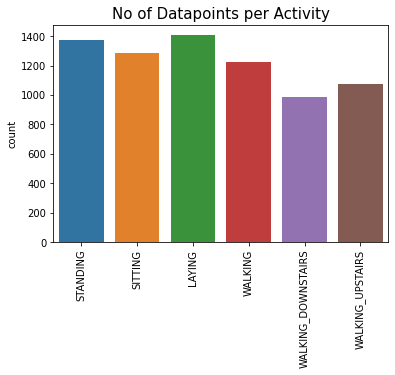

In [ ]:
plt.title('No of Datapoints per Activity', fontsize=15)
ax = sns.countplot(pd.Series(y_train).map(labels))
plt.xticks(rotation=90)
plt.show()

Our classes are almost balanced so we can ignore some imbalance, but we will measure our models' performance using **F1 score** function to make sure it works well.

<a name="reduction"></a>

####Dimensionality Reduction

**Principal Component Analysis (PCA)** is a dimensionality reduction method that finds new features with maximum possible fraction of original features' variance and these new features are linearly dependent on original features. It works by finding eigen vectors of the covariance matrix. Although using **PCA** can be a bad practice in production stage because maximum variance doesn't guarantee maximum information and it can increase probability of information loss.

But for comparision purposes, PCA is not a bad idea, because even if it cause some information loss, stil data will be the same for all target models to be expermented.

It is a common knowledge to keep about 90% ~ 99% of original variance in PCA procedure. here we will keep **95% of the original variance**, now lets apply PCA with 95% of the original variance:





In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) 
pca = pca.fit(df_train)
x_train_pca = pd.DataFrame(pca.transform(df_train))
x_test_pca = pd.DataFrame(pca.transform(df_test))

Now lets see how many features PCA has generated for us:

In [ ]:
len(x_train_pca.columns)

67

Not bad! PCA found 67 new features that have 95% variance of the original features, it means that we lost 5% of our variance but got a dataset with 88% less features!

<a name="comparator"></a>

#Preparing Comparator 🔍

---

Here we implement a central unique comparator method which takes model object, its name and space of hyper parameter and also full dataset and does 3 things:
 - Tuning model's hyper parameters combined with k-fold validation
 - Plotting chart of hyper parameters convergence
 - Training the model using best hyper parameters
 - Reporting model's confusion matrix on test set
 - Returning model's score on train and test set

In [ ]:
def examine_model(model, model_name, space, x_train, y_train, test_data, report):
    """  
    model: object of the model to test

    model_name: name of method, this will be displayed in the report

    space: a list of skopt objects that represent space of possible 
            parameters for model's variables.

    x_train: features of the training set

    y_train: labels of the training set to predict

    test_data: (x_test, y_test) tupple for testing final score.

    report: a dictionary containing all models score values
    
    return: inputed report dictionary but current model's score is appended
    """
    
    # This is the loss function that will be passed to skopt algorithm
    # to maximize hyper parameters score 
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)

        return -np.mean(cross_val_score(model, x_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

    # Tuning the hyper parameters using bayesian optimizer from skopt
    res_gp = gp_minimize(objective, space, n_calls=20, random_state=7)

    # plotting the history of hyper parameters score
    # during optimization
    plot_convergence(res_gp)
    plt.show()

    # gp_minimize return a list of hyper parameters but sklearn classes
    # have set_params methods which accept a dictionary, so here we 
    # convert hyper parameters final values from res_gp.x to dictu
    params = {}
    for i, var in enumerate(space):
        params[var.name] = res_gp.x[i]

    # Setting best hyper parameters found for the model
    model.set_params(**params)

    # Training the tunned model
    model.fit(x_train, y_train)
    
    # In this part we calculate model's score on test data
    # with multiple functions (accuracy, precision, recall, f1 score)
    # Please notice that test data is not used for training nor tunning,
    # so it is the best way to measure overfitting of the model
    y_hat = model.predict(test_data[0])
    cm = metrics.confusion_matrix(test_data[1], y_hat)
    sns.heatmap(cm, annot=True)

    acc = metrics.accuracy_score(test_data[1], y_hat)
    recall = metrics.recall_score(test_data[1], y_hat, average='micro')
    precision = metrics.precision_score(test_data[1], y_hat, average='micro')
    f1_score = metrics.f1_score(test_data[1], y_hat, average='micro')

    print(f"Accuracy of '{model_name}' = {acc}")
    print(f"Recall of '{model_name}' = {recall}")
    print(f"Precision of '{model_name}' = {precision}")
    print(f"F1 Score of '{model_name}' = {f1_score}")

    # inserting model's score values into report dictionary
    report[model_name] = (acc, precision, recall, f1_score)
    return report


Now our comparator method is ready to use!

<a name="models"></a>

#Models 🤖

---

We examine and compare performance of 5 models:

 - Logistic Regression
 - Decission Tree Classifier
 - Random Forest Classifier
 - Support Vector Machine Classifier
 - KNeighbors Classifier

 but before beginning to examine the models, we should define a dictionary to keep score of our models, we will use this dictionary for final conclusion:

In [ ]:
report = {} # Keeps score values of our models

<a name="logistic-regressor"></a>

####Logistic Regression

Logistic Regression method is made by applying sigmoid function on Linear Regression's output. It can be seen as a 1 layer neural network with sigmoid function as its activation function. Although it is not as intelligent as deep neural networks, but many data scientist begin their analysis by testing Logistic Regression and then they deepen their models!

So now lets see how it performs on our dataset:



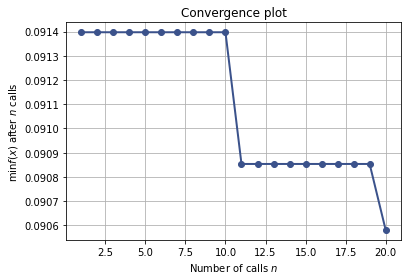

Accuracy of 'Logistic Regression' = 0.9412962334577536
Recall of 'Logistic Regression' = 0.9412962334577536
Precision of 'Logistic Regression' = 0.9412962334577536
F1 Score of 'Logistic Regression' = 0.9412962334577536


{'Random Forest': (0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474),
 'SVC': (0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576),
 'KNeighbours': (0.9039701391245334,
  0.9039701391245334,
  0.9039701391245334,
  0.9039701391245334),
 'Logistic Regression': (0.9412962334577536,
  0.9412962334577536,
  0.9412962334577536,
  0.9412962334577536)}

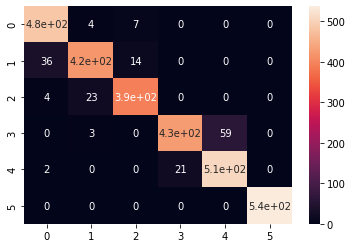

In [ ]:
space  = [Real(0.5, 3, name='C')]

regressor = LogisticRegression()

examine_model(regressor, 'Logistic Regression', space, x_train_pca, y_train, (x_test_pca, y_test), report)

<a name="decision-tree"></a>

####Decision Tree

Decision Tree is a classification method which divides cases into different branches of a tree and every branch represents a condition which sieves the cases of dataset. each leaf of the tree is made up of a unique set of conditions to sieve cases.

Now lets see how it performs on our dataset:



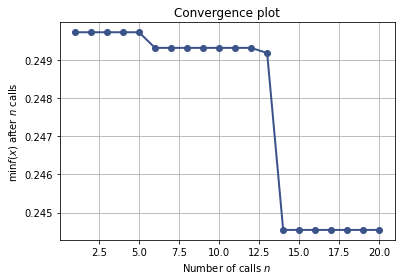

Accuracy of 'Decision Tree' = 0.8065829657278588
Recall of 'Decision Tree' = 0.8065829657278588
Precision of 'Decision Tree' = 0.8065829657278588
F1 Score of 'Decision Tree' = 0.8065829657278588


{'Random Forest': (0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474),
 'SVC': (0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576),
 'KNeighbours': (0.9039701391245334,
  0.9039701391245334,
  0.9039701391245334,
  0.9039701391245334),
 'Logistic Regression': (0.9412962334577536,
  0.9412962334577536,
  0.9412962334577536,
  0.9412962334577536),
 'Decision Tree': (0.8065829657278588,
  0.8065829657278588,
  0.8065829657278588,
  0.8065829657278588)}

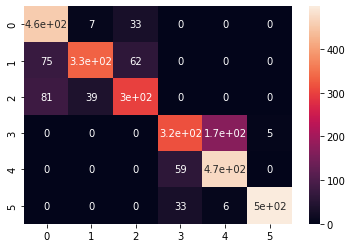

In [ ]:
space  = [
        Integer(5, 100, name='max_depth'),
        Integer(2, 10, name='min_samples_split'),
        Integer(2, 5, name='min_samples_leaf')
        ]

tree = DecisionTreeClassifier()

examine_model(tree, 'Decision Tree', space, x_train_pca, y_train, (x_test_pca, y_test), report)

<a name="random-forest"></a>

####Random Forest

Random Forest method is a kind of ensemble method. Ensemble methods make multiple instance of other methods and define final output as combination of these models. Random forest adds more randomness to the model while growing trees which increases the expected value of the model's score. This model is a very sophisticated competent for shallow neural networks and even before the ero of deep learning, many companies used this model in production level. For example Microsoft used Random Forest in its Kinect game console.

Now lets see how it performs on our dataset:


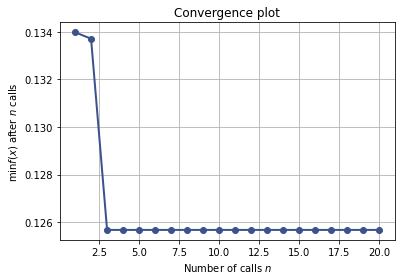

Accuracy of 'Random Forest' = 0.9063454360366474
Recall of 'Random Forest' = 0.9063454360366474
Precision of 'Random Forest' = 0.9063454360366474
F1 Score of 'Random Forest' = 0.9063454360366474


{'Random Forest': (0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474)}

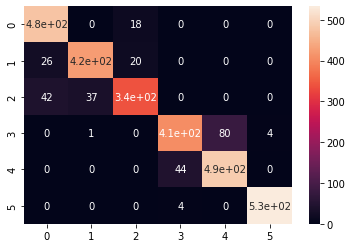

In [ ]:
space  = [
        Integer(50, 500, name='n_estimators'),
        Integer(2, 10, name='min_samples_split'),
        Integer(2, 5, name='min_samples_leaf')
        ]

forest = RandomForestClassifier()

examine_model(forest, 'Random Forest', space, x_train_pca, y_train, (x_test_pca, y_test), report)

<a name="svm"></a>

####Support Vector Machine

**Support Vector Machine (SVM)** is a popular discriminative machine learning algorithm which seeks to find not only best possible score of prediction on training set, but I also it tries to find the best bound between classes with maximizing the margin between the bound and members of each class. In fact support vectors are the vector from boundary of the class teritory to the nearest member of the class to this boundry.

Anyway, lets see how this method performs on our dataset:


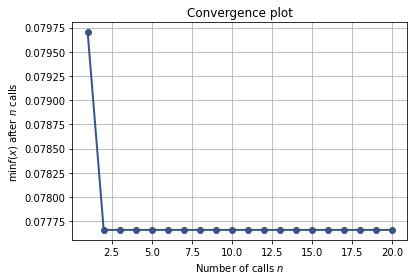

Accuracy of 'SVC' = 0.9419748897183576
Recall of 'SVC' = 0.9419748897183576
Precision of 'SVC' = 0.9419748897183576
F1 Score of 'SVC' = 0.9419748897183576


{'Random Forest': (0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474),
 'SVC': (0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576)}

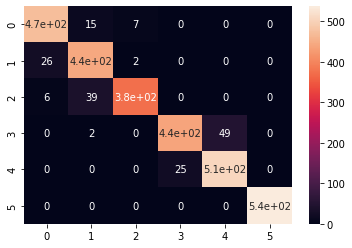

In [ ]:
space  = [Real(0.5, 2, name='C'),
          Integer(1, 6, name='degree')]

regressor = SVC()

examine_model(regressor, 'SVC', space, x_train_pca, y_train, (x_test_pca, y_test), report)

<a name="kneighbors"></a>

####KNeighbors Classifier

KNearest Neighbors (KNN) is an unsupervised machine learning algorithm which is used for clustering problems. It is an iterative methods which finally finds custom amount of cluster with minimum amount of aggregated distance between points of each cluster, in fact this method has potential to fall in a local minima but using it for multiple times can increase the probability of finding the global minima.

Anyway, we can use KNN to cluster our training cases into k cluster which k is equal to number of classes in our classification problem, then in the test stage we check the cluster that our test case falls on so we report class of this cluster as class of our test case.

Now lets see how it performs on our dataset:



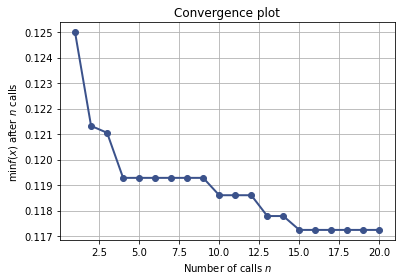

Accuracy of 'KNeighbours' = 0.9039701391245334
Recall of 'KNeighbours' = 0.9039701391245334
Precision of 'KNeighbours' = 0.9039701391245334
F1 Score of 'KNeighbours' = 0.9039701391245334


{'Random Forest': (0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474,
  0.9063454360366474),
 'SVC': (0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576,
  0.9419748897183576),
 'KNeighbours': (0.9039701391245334,
  0.9039701391245334,
  0.9039701391245334,
  0.9039701391245334)}

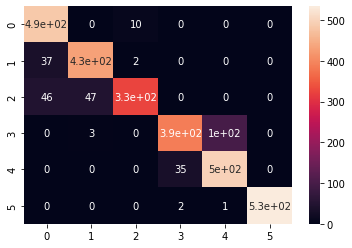

In [ ]:
space  = [Integer(2, 30, name='n_neighbors')]

kneighbors = KNeighborsClassifier()

examine_model(kneighbors, 'KNeighbours', space, x_train_pca, y_train, (x_test_pca, y_test), report)

<a name="together"></a>

#Final Statistics 📊

---

No we will show scores of all models in a bar plot to visualize their comparision.

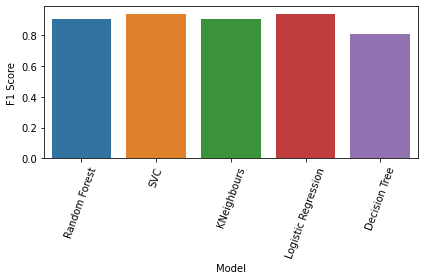

In [ ]:
comp_data = [
            [key, scores[0]]
            for key, scores in report.items()
            ]

comp_data = pd.DataFrame(comp_data, columns=['Model', 'F1 Score'])

sns.barplot(data=comp_data, x='Model', y='F1 Score')
plt.xticks(rotation=70)
plt.tight_layout()

So in the end it seems that these models can perform equivalently well but SVC and Logistic Regression got a little more score. Also this is our models' score on test set which was not used during tunning nor training, so it represents pure performance of these models.
